# Sign Language Recognition using Deep Learning

โปรเจกต์นี้สร้าง AI Model สำหรับจำแนก Sign Language โดยใช้ Sign Language MNIST Dataset

## เนื้อหา
1. ติดตั้ง Libraries และโหลด Dataset
2. สำรวจข้อมูล (Exploratory Data Analysis)
3. เตรียมข้อมูล (Data Preprocessing)
4. สร้าง Model แบบ CNN
5. สร้าง Model แบบ Transfer Learning
6. Train และประเมินผล Models
7. บันทึก Model และทดสอบ

## 1. Import Libraries และ Download Dataset

**Alternative (สำหรับ Google Colab)**:  
หากรันบน Colab และต้องการติดตั้งด้วยคำสั่งง่ายๆ ให้ใช้:
```python
!pip install -q kagglehub tensorflow numpy pandas matplotlib seaborn scikit-learn opencv-python Pillow
```

In [30]:
# ติดตั้ง dependencies ตาม requirements.txt
# สำหรับ Google Colab หรือสภาพแวดล้อมใหม่

import sys
import subprocess

def install_requirements():
    """ติดตั้ง packages จากไฟล์ requirements.txt"""
    try:
        print("กำลังติดตั้ง dependencies...")
        print("="*60)
        
        # ติดตั้งจากไฟล์ requirements.txt
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt", "-q"])
        
        print("="*60)
        print("✅ ติดตั้ง dependencies สำเร็จ!")
        print("\nหมายเหตุ: ถ้าติดตั้งไว้แล้ว จะข้ามการติดตั้งซ้ำโดยอัตโนมัติ")
        
    except FileNotFoundError:
        print("⚠️  ไม่พบไฟล์ requirements.txt")
        print("กำลังติดตั้ง packages หลักๆ...")
        
        # ติดตั้ง packages หลักๆ ถ้าไม่มีไฟล์ requirements.txt
        packages = [
            "kagglehub",
            "tensorflow>=2.13.0",
            "numpy>=1.24.0",
            "pandas>=2.0.0",
            "matplotlib>=3.7.0",
            "seaborn>=0.12.0",
            "scikit-learn>=1.3.0",
            "opencv-python>=4.8.0",
            "Pillow>=10.0.0"
        ]
        
        for package in packages:
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
                print(f"✅ ติดตั้ง {package}")
            except:
                print(f"❌ ติดตั้ง {package} ล้มเหลว")
        
        print("\n✅ ติดตั้ง dependencies เสร็จสิ้น!")
    
    except Exception as e:
        print(f"❌ เกิดข้อผิดพลาด: {str(e)}")
        print("\nคุณสามารถติดตั้งด้วยตนเองโดยรันคำสั่ง:")
        print("!pip install -r requirements.txt")

# รันการติดตั้ง
install_requirements()

กำลังติดตั้ง dependencies...
✅ ติดตั้ง dependencies สำเร็จ!

หมายเหตุ: ถ้าติดตั้งไว้แล้ว จะข้ามการติดตั้งซ้ำโดยอัตโนมัติ


## 0. ติดตั้ง Dependencies (ถ้ายังไม่ได้ติดตั้ง)

**หมายเหตุ**: ถ้าคุณรัน Notebook ใน Google Colab หรือสภาพแวดล้อมใหม่ ให้รัน cell นี้ก่อน  
ถ้าติดตั้ง dependencies ไว้แล้ว สามารถข้ามไปยัง Section 1 ได้เลย

In [31]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

# ML Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Kaggle
import kagglehub

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


In [32]:
# Download dataset from Kaggle
print("Downloading Sign Language MNIST dataset...")
path = kagglehub.dataset_download("datamunge/sign-language-mnist")
print(f"Path to dataset files: {path}")

Path to dataset files: /Users/karitthorn/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1


In [33]:
# โหลดข้อมูล
train_df = pd.read_csv(os.path.join(path, 'sign_mnist_train.csv'))
test_df = pd.read_csv(os.path.join(path, 'sign_mnist_test.csv'))

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")
print(f"\nFirst few rows:")
print(train_df.head())

Training data shape: (27455, 785)
Testing data shape: (7172, 785)

First few rows:
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133      

## 2. Exploratory Data Analysis (EDA)

In [34]:
# แสดงข้อมูลสถิติ
print("Dataset Information:")
print(f"Number of training samples: {len(train_df)}")
print(f"Number of test samples: {len(test_df)}")
print(f"Number of features: {train_df.shape[1] - 1}")  # ลบ label column
print(f"Number of classes: {train_df['label'].nunique()}")
print(f"\nClass distribution in training set:")
print(train_df['label'].value_counts().sort_index())

Dataset Information:
Number of training samples: 27455
Number of test samples: 7172
Number of features: 784
Number of classes: 24

Class distribution in training set:
label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: count, dtype: int64


In [35]:
# สร้าง label mapping (A-Z ยกเว้น J)
# Dataset มี labels 0-24 (25 ค่า) ที่แทน A-Y ยกเว้น J
# 0=A, 1=B, ..., 8=I, 9=K (ข้ามJ), 10=L, ..., 24=Y
label_map = {}
for i in range(25):
    if i < 9:
        label_map[i] = chr(65 + i)  # A-I
    elif i == 9:
        label_map[i] = 'J'  # ไม่มีในข้อมูลจริง แต่ใส่ไว้เผื่อ
    else:
        label_map[i] = chr(65 + i)  # K-Y

print("Label Mapping:")
print(label_map)

Label Mapping:
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}


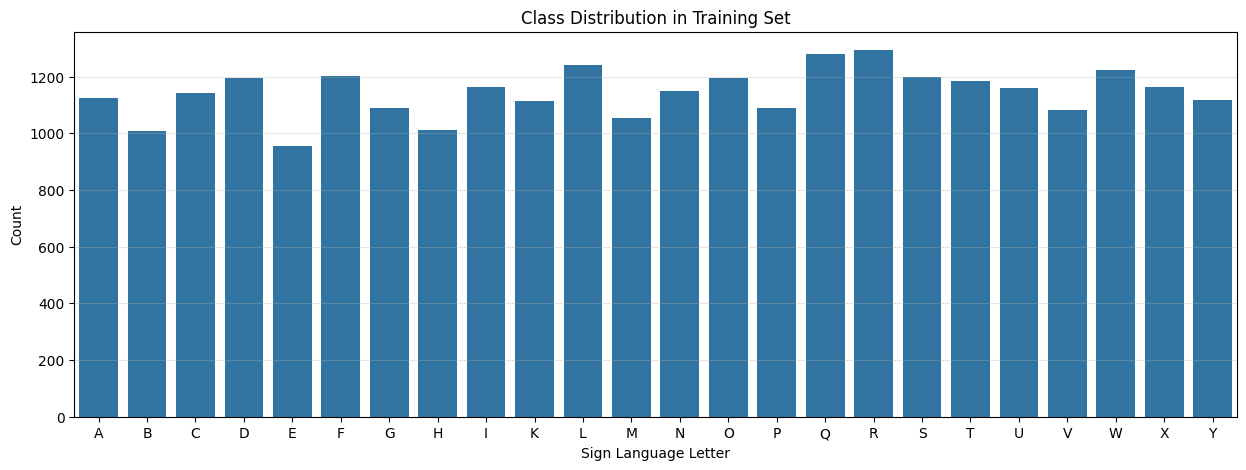

In [36]:
# แสดง class distribution
plt.figure(figsize=(15, 5))
sns.countplot(data=train_df, x='label')
plt.title('Class Distribution in Training Set')
plt.xlabel('Sign Language Letter')
plt.ylabel('Count')

# สร้าง x-tick labels จากคลาสที่มีจริง
available_classes = sorted(train_df['label'].unique())
plt.xticks(range(len(available_classes)), [label_map[i] for i in available_classes])
plt.grid(axis='y', alpha=0.3)
plt.show()

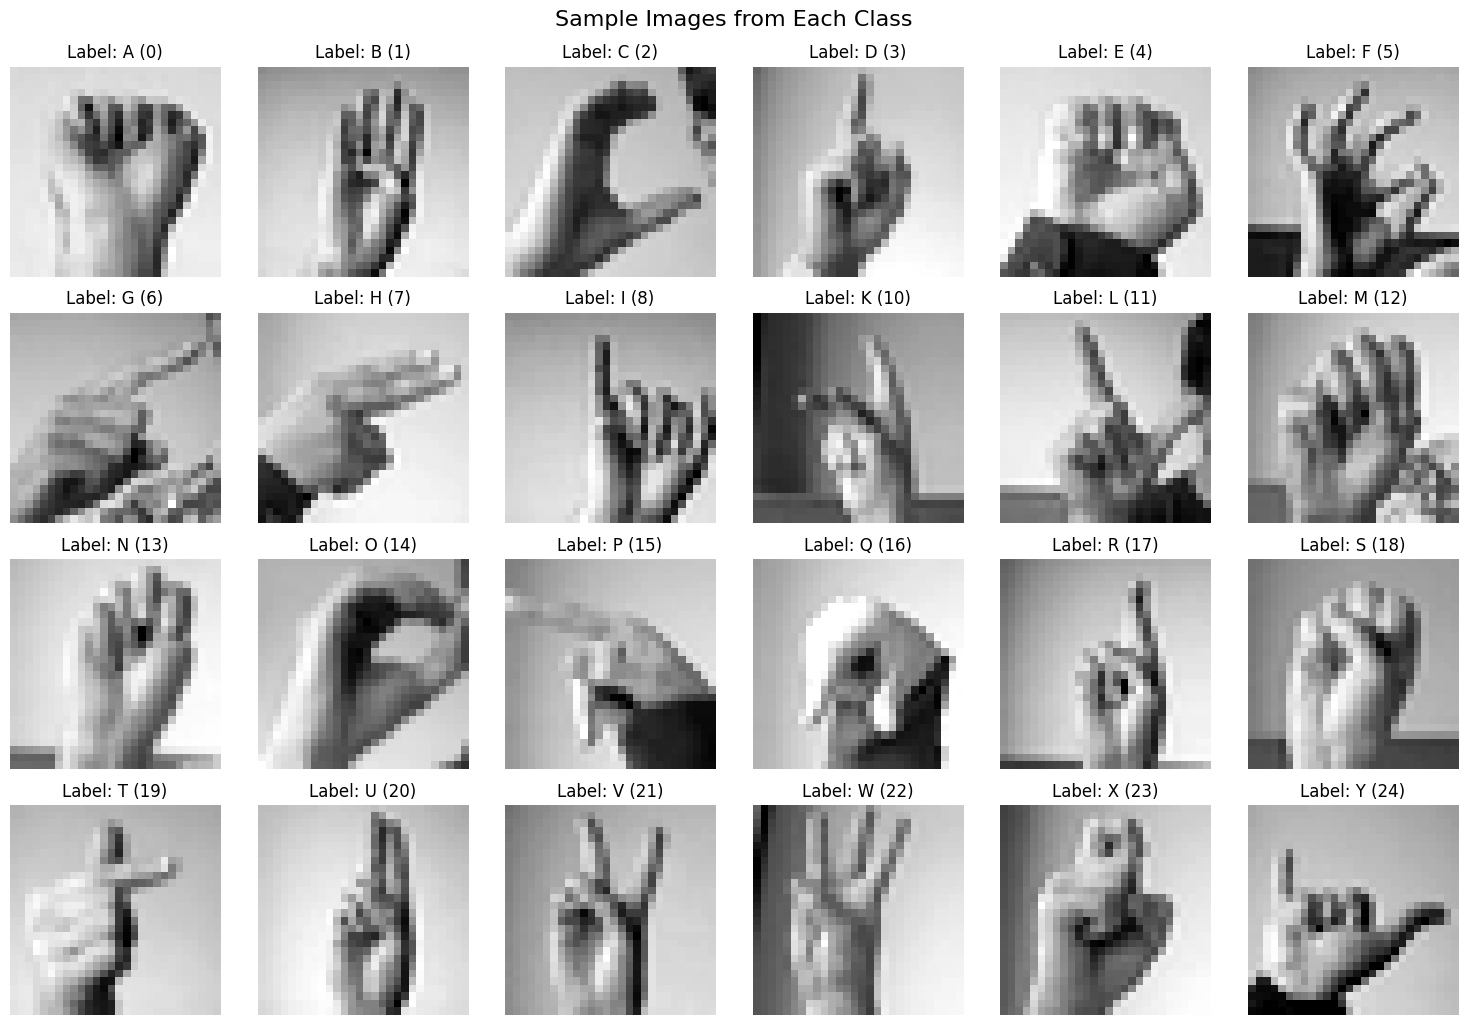

In [37]:
# แสดงตัวอย่างภาพจากแต่ละคลาส
def display_sample_images(df, n_samples=24):
    # ตรวจสอบคลาสที่มีจริงใน dataset
    available_classes = sorted(df['label'].unique())
    n_samples = min(n_samples, len(available_classes))
    
    fig, axes = plt.subplots(4, 6, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, label_num in enumerate(available_classes[:n_samples]):
        # เลือกภาพแรกของแต่ละคลาส
        sample = df[df['label'] == label_num].iloc[0]
        pixels = sample[1:].values.reshape(28, 28)
        
        axes[i].imshow(pixels, cmap='gray')
        axes[i].set_title(f'Label: {label_map.get(label_num, "?")} ({label_num})')
        axes[i].axis('off')
    
    # ปิด axes ที่ไม่ได้ใช้
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample Images from Each Class', y=1.02, fontsize=16)
    plt.show()

display_sample_images(train_df)

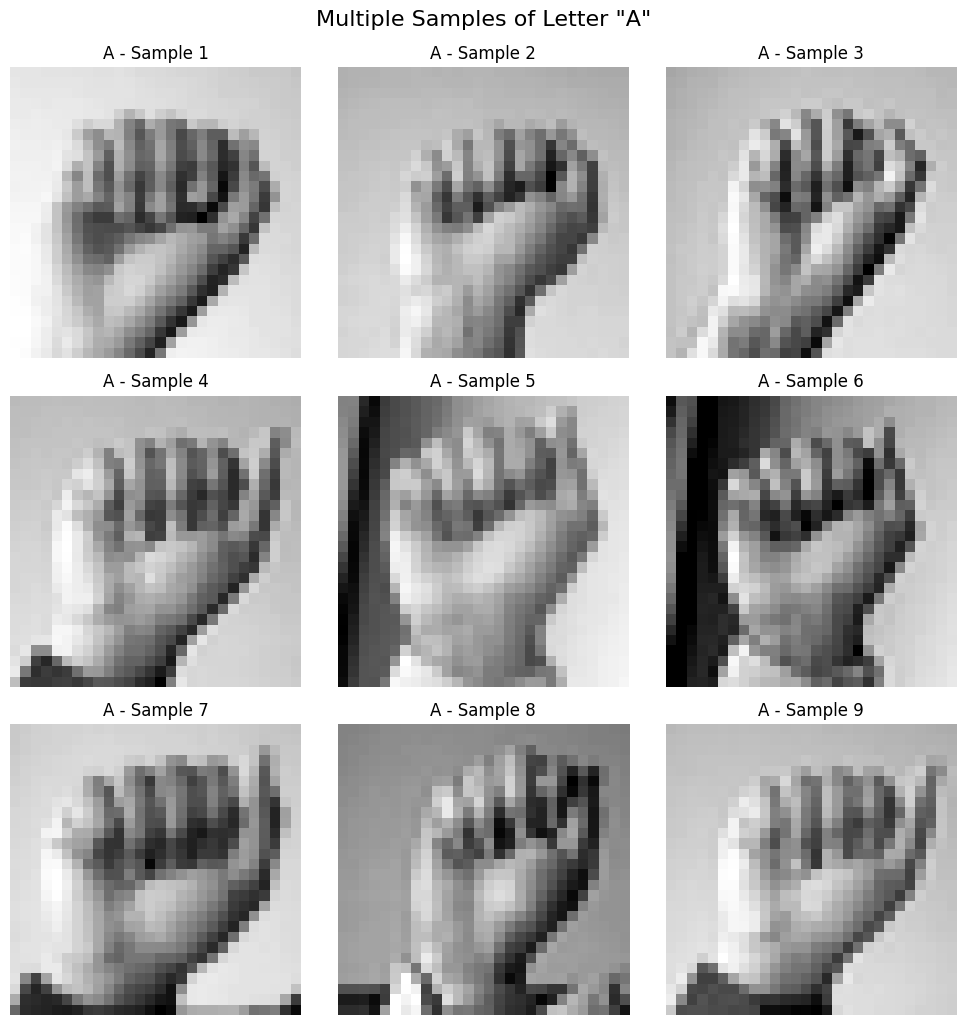

In [38]:
# แสดงตัวอย่างหลายภาพจากคลาสเดียวกัน
def display_multiple_samples(df, label_num, n_samples=9):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    
    samples = df[df['label'] == label_num].sample(n_samples)
    
    for i, (idx, sample) in enumerate(samples.iterrows()):
        pixels = sample[1:].values.reshape(28, 28)
        axes[i].imshow(pixels, cmap='gray')
        axes[i].set_title(f'{label_map[label_num]} - Sample {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'Multiple Samples of Letter "{label_map[label_num]}"', y=1.02, fontsize=16)
    plt.show()

# แสดงตัวอย่างหลายภาพของตัวอักษร 'A' (label 0)
display_multiple_samples(train_df, label_num=0)

## 3. Data Preprocessing

In [39]:
# แยก features และ labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

# Reshape เป็น 28x28x1 (grayscale)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalize pixel values (0-255 -> 0-1)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (27455, 28, 28, 1)
y_train shape: (27455,)
X_test shape: (7172, 28, 28, 1)
y_test shape: (7172,)


In [40]:
# แบ่ง validation set จาก training set (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42,
    stratify=y_train  # รักษาสัดส่วนของแต่ละคลาส
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 21964 samples
Validation set: 5491 samples
Test set: 7172 samples


In [41]:
# One-hot encode labels
# Dataset มี labels 0-24 (25 คลาส) แม้ว่าจะไม่มีคลาส 9 (J)
num_classes = 25
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_val_cat = keras.utils.to_categorical(y_val, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

print(f"One-hot encoded labels shape: {y_train_cat.shape}")
print(f"Number of classes: {num_classes} (labels 0-24, excluding 9 which is J)")

One-hot encoded labels shape: (21964, 25)
Number of classes: 25 (labels 0-24, excluding 9 which is J)


In [42]:
# Data Augmentation สำหรับ training set
train_datagen = ImageDataGenerator(
    rotation_range=10,          # หมุนภาพ ±10 องศา
    width_shift_range=0.1,      # เลื่อนภาพแนวนอน
    height_shift_range=0.1,     # เลื่อนภาพแนวตั้ง
    zoom_range=0.1,             # ซูมเข้า-ออก
    shear_range=0.1,            # บิดภาพ
    fill_mode='nearest'         # เติมพิกเซลที่ว่าง
)

# Validation/Test ไม่ต้อง augment
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

print("Data augmentation configured successfully!")

Data augmentation configured successfully!


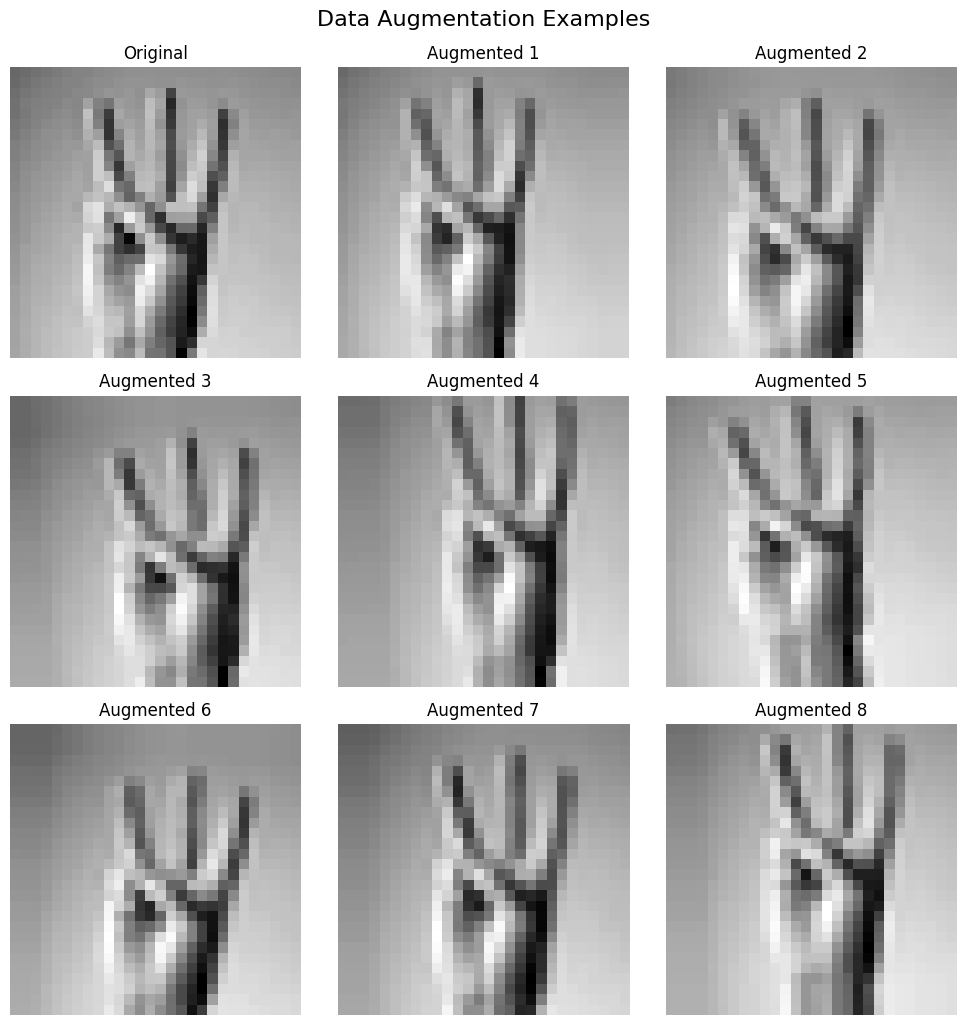

In [43]:
# แสดงตัวอย่าง augmented images
def show_augmented_images(image, n_samples=9):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    
    # Original image
    axes[0].imshow(image.reshape(28, 28), cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Augmented images
    image_reshaped = image.reshape(1, 28, 28, 1)
    aug_iter = train_datagen.flow(image_reshaped, batch_size=1)
    
    for i in range(1, n_samples):
        aug_image = next(aug_iter)[0]
        axes[i].imshow(aug_image.reshape(28, 28), cmap='gray')
        axes[i].set_title(f'Augmented {i}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Data Augmentation Examples', y=1.02, fontsize=16)
    plt.show()

# แสดงตัวอย่าง augmentation
sample_image = X_train[0]
show_augmented_images(sample_image)

## 4. สร้าง CNN Model (แบบพื้นฐาน)

In [44]:
def create_cnn_model(input_shape=(28, 28, 1), num_classes=25):
    """
    สร้าง CNN Model พื้นฐานสำหรับจำแนก Sign Language
    """
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# สร้าง model
cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 621,049 (2.37 MB)

 Trainable params: 619,385 (2.36 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [45]:
# Compile model
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("CNN Model compiled successfully!")

CNN Model compiled successfully!


In [46]:
# Define Callbacks
callbacks = [
    ModelCheckpoint(
        'best_cnn_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured!")

Callbacks configured!


In [47]:
# Train CNN Model
batch_size = 128
epochs = 50

print("Starting training CNN model...")
history_cnn = cnn_model.fit(
    train_datagen.flow(X_train, y_train_cat, batch_size=batch_size),
    validation_data=(X_val, y_val_cat),
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting training CNN model...
Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.1425 - loss: 3.4898
Epoch 1: val_accuracy improved from None to 0.06301, saving model to best_cnn_model.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 34s 178ms/step - accuracy: 0.2618 - loss: 2.6924 - val_accuracy: 0.0630 - val_loss: 3.7124 - learning_rate: 0.0010
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5903 - loss: 1.2220
Epoch 2: val_accuracy improved from 0.06301 to 0.08323, saving model to best_cnn_model.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 31s 177ms/step - accuracy: 0.6534 - loss: 1.0360 - val_accuracy: 0.0832 - val_loss: 4.5043 - learning_rate: 0.0010
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8066 - loss: 0.6068
Epoch 3: val_accuracy improved from 0.08323 to 0.88709, saving model to best_cnn_model.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 32s 185ms/step - accuracy: 0.8282 - loss: 0.5343 - val_accuracy: 0.8871 - val_loss: 0.4034 - learning_rate: 0.00

KeyboardInterrupt: 

In [ ]:
# Plot training history
def plot_training_history(history, title_prefix=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title(f'{title_prefix} Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title(f'{title_prefix} Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_cnn, 'CNN')

## 5. สร้าง Transfer Learning Model (MobileNetV2)

In [ ]:
# เตรียมข้อมูลสำหรับ Transfer Learning (ต้องการ 3 channels)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Resize เป็น 96x96 (ขนาดที่ MobileNetV2 รองรับ)
X_train_resized = tf.image.resize(X_train_rgb, [96, 96]).numpy()
X_val_resized = tf.image.resize(X_val_rgb, [96, 96]).numpy()
X_test_resized = tf.image.resize(X_test_rgb, [96, 96]).numpy()

print(f"Resized training data shape: {X_train_resized.shape}")

In [ ]:
def create_transfer_learning_model(input_shape=(96, 96, 3), num_classes=25):
    """
    สร้าง Transfer Learning Model โดยใช้ MobileNetV2
    """
    # โหลด pre-trained MobileNetV2
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # สร้าง model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

# สร้าง model
transfer_model, base_model = create_transfer_learning_model()
transfer_model.summary()

In [ ]:
# Compile Transfer Learning model
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Transfer Learning Model compiled successfully!")

In [ ]:
# Callbacks สำหรับ Transfer Learning
tl_callbacks = [
    ModelCheckpoint(
        'best_transfer_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [ ]:
# Data Augmentation สำหรับ Transfer Learning
tl_train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    shear_range=0.15,
    horizontal_flip=False,  # ไม่ flip เพราะ Sign Language มีทิศทาง
    fill_mode='nearest'
)

print("Data augmentation for Transfer Learning configured!")

In [ ]:
# Train Transfer Learning Model (Phase 1: Frozen base)
print("Phase 1: Training with frozen base model...")
history_tl = transfer_model.fit(
    tl_train_datagen.flow(X_train_resized, y_train_cat, batch_size=64),
    validation_data=(X_val_resized, y_val_cat),
    epochs=20,
    callbacks=tl_callbacks,
    verbose=1
)

print("\nPhase 1 training completed!")

In [ ]:
# Fine-tuning: Unfreeze ชั้นบนสุดของ base model
print("Phase 2: Fine-tuning...")
base_model.trainable = True

# Freeze ชั้นแรกๆ ไว้ (fine-tune เฉพาะชั้นบนสุด)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Compile ใหม่ด้วย learning rate ต่ำ
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable layers: {sum([1 for layer in transfer_model.layers if layer.trainable])}")

In [ ]:
# Train Phase 2: Fine-tuning
history_tl_ft = transfer_model.fit(
    tl_train_datagen.flow(X_train_resized, y_train_cat, batch_size=64),
    validation_data=(X_val_resized, y_val_cat),
    epochs=20,
    callbacks=tl_callbacks,
    verbose=1
)

print("\nFine-tuning completed!")

In [ ]:
# Plot Transfer Learning history
plot_training_history(history_tl, 'Transfer Learning (Phase 1)')
plot_training_history(history_tl_ft, 'Transfer Learning (Phase 2 - Fine-tuned)')

## 6. ประเมินผล Models

In [ ]:
# Evaluate CNN Model
print("Evaluating CNN Model...")
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"CNN Test Accuracy: {cnn_accuracy*100:.2f}%")
print(f"CNN Test Loss: {cnn_loss:.4f}")

# Predictions
cnn_predictions = cnn_model.predict(X_test)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

In [ ]:
# Evaluate Transfer Learning Model
print("Evaluating Transfer Learning Model...")
tl_loss, tl_accuracy = transfer_model.evaluate(X_test_resized, y_test_cat, verbose=0)
print(f"Transfer Learning Test Accuracy: {tl_accuracy*100:.2f}%")
print(f"Transfer Learning Test Loss: {tl_loss:.4f}")

# Predictions
tl_predictions = transfer_model.predict(X_test_resized)
tl_pred_classes = np.argmax(tl_predictions, axis=1)

In [ ]:
# เปรียบเทียบผลลัพธ์
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"{'Model':<30} {'Accuracy':<15} {'Loss':<10}")
print("-"*50)
print(f"{'CNN (Custom)':<30} {cnn_accuracy*100:>6.2f}%        {cnn_loss:>6.4f}")
print(f"{'Transfer Learning (MobileNetV2)':<30} {tl_accuracy*100:>6.2f}%        {tl_loss:>6.4f}")
print("="*50)

In [ ]:
# Classification Report for CNN
# สร้าง target names สำหรับคลาสที่มีจริงใน dataset
available_labels = sorted(np.unique(y_test))
target_names = [label_map[i] for i in available_labels]

print("\nCNN Model - Classification Report:")
print(classification_report(
    y_test, 
    cnn_pred_classes, 
    labels=available_labels,
    target_names=target_names
))

In [ ]:
# Classification Report for Transfer Learning
print("\nTransfer Learning Model - Classification Report:")
print(classification_report(
    y_test, 
    tl_pred_classes, 
    labels=available_labels,
    target_names=target_names
))

In [ ]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    # ใช้เฉพาะ labels ที่มีจริงใน dataset
    available_labels = sorted(np.unique(y_true))
    label_names = [label_map[i] for i in available_labels]
    
    cm = confusion_matrix(y_true, y_pred, labels=available_labels)
    
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names,
                yticklabels=label_names,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_test, cnn_pred_classes, 'CNN Model - Confusion Matrix')
plot_confusion_matrix(y_test, tl_pred_classes, 'Transfer Learning Model - Confusion Matrix')

## 7. บันทึก Model และทดสอบ

In [ ]:
# บันทึก models
cnn_model.save('sign_language_cnn_final.keras')
transfer_model.save('sign_language_transfer_final.keras')

print("Models saved successfully!")
print("- sign_language_cnn_final.keras")
print("- sign_language_transfer_final.keras")

In [ ]:
# ฟังก์ชันทดสอบการทำนาย
def predict_sign_language(model, image, model_type='cnn'):
    """
    ทำนาย Sign Language จากภาพ
    
    Args:
        model: trained model
        image: numpy array ของภาพ (28x28x1)
        model_type: 'cnn' หรือ 'transfer'
    """
    # เตรียมภาพ
    if model_type == 'transfer':
        # Convert to RGB and resize
        image_rgb = np.repeat(image, 3, axis=-1)
        image_processed = tf.image.resize(image_rgb, [96, 96]).numpy()
    else:
        image_processed = image
    
    # Reshape สำหรับการทำนาย
    image_input = image_processed.reshape(1, *image_processed.shape)
    
    # ทำนาย
    prediction = model.predict(image_input, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    return predicted_class, confidence, prediction[0]

In [ ]:
# ทดสอบด้วยภาพสุ่มจาก test set
def test_random_predictions(n_samples=10):
    """
    ทดสอบการทำนายด้วยภาพสุ่ม
    """
    # สุ่มภาพ
    random_indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for idx, test_idx in enumerate(random_indices):
        # ภาพจริง
        image = X_test[test_idx]
        true_label = y_test[test_idx]
        
        # ทำนายด้วย CNN
        pred_class_cnn, conf_cnn, _ = predict_sign_language(cnn_model, image, 'cnn')
        
        # ทำนายด้วย Transfer Learning
        pred_class_tl, conf_tl, _ = predict_sign_language(transfer_model, image, 'transfer')
        
        # แสดงผล
        axes[idx].imshow(image.reshape(28, 28), cmap='gray')
        
        title = f"True: {label_map[true_label]}\n"
        title += f"CNN: {label_map[pred_class_cnn]} ({conf_cnn*100:.1f}%)\n"
        title += f"TL: {label_map[pred_class_tl]} ({conf_tl*100:.1f}%)"
        
        # เปลี่ยนสีถ้าทำนายผิด
        color = 'green' if (pred_class_cnn == true_label and pred_class_tl == true_label) else 'red'
        axes[idx].set_title(title, fontsize=10, color=color)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Random Test Predictions Comparison', y=1.02, fontsize=16)
    plt.show()

# ทดสอบ
test_random_predictions(10)

In [ ]:
# แสดง Top-3 predictions สำหรับแต่ละภาพ
def show_top_predictions(image_idx, model, model_type='cnn', model_name='Model'):
    """
    แสดง Top-3 predictions พร้อมความมั่นใจ
    """
    image = X_test[image_idx]
    true_label = y_test[image_idx]
    
    pred_class, confidence, all_probs = predict_sign_language(model, image, model_type)
    
    # Top-3
    top_3_idx = np.argsort(all_probs)[-3:][::-1]
    top_3_probs = all_probs[top_3_idx]
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # แสดงภาพ
    ax1.imshow(image.reshape(28, 28), cmap='gray')
    ax1.set_title(f'True Label: {label_map[true_label]}', fontsize=14)
    ax1.axis('off')
    
    # แสดง Top-3 predictions
    labels = [label_map[i] for i in top_3_idx]
    colors = ['green' if top_3_idx[0] == true_label else 'red', 'orange', 'blue']
    
    ax2.barh(labels, top_3_probs, color=colors)
    ax2.set_xlabel('Confidence', fontsize=12)
    ax2.set_title(f'{model_name} - Top 3 Predictions', fontsize=14)
    ax2.set_xlim([0, 1])
    
    for i, (label, prob) in enumerate(zip(labels, top_3_probs)):
        ax2.text(prob + 0.01, i, f'{prob*100:.1f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# ทดสอบกับภาพสุ่ม
random_idx = np.random.randint(0, len(X_test))
show_top_predictions(random_idx, cnn_model, 'cnn', 'CNN Model')
show_top_predictions(random_idx, transfer_model, 'transfer', 'Transfer Learning Model')

## สรุปผลการทดลอง

### Models ที่สร้าง:
1. **CNN Model**: Custom CNN architecture
2. **Transfer Learning Model**: MobileNetV2 + Fine-tuning

### ไฟล์ที่บันทึก:
- `best_cnn_model.keras` - Best CNN model during training
- `best_transfer_model.keras` - Best Transfer Learning model during training
- `sign_language_cnn_final.keras` - Final CNN model
- `sign_language_transfer_final.keras` - Final Transfer Learning model

### วิธีใช้งาน Model:
```python
# โหลด model
model = keras.models.load_model('sign_language_cnn_final.keras')

# เตรียมภาพ (28x28x1, normalized)
image = your_image / 255.0
image = image.reshape(1, 28, 28, 1)

# ทำนาย
prediction = model.predict(image)
predicted_class = np.argmax(prediction)
print(f"Predicted: {label_map[predicted_class]}")
```

### การพัฒนาต่อ:
1. ลองใช้ model architectures อื่นๆ (EfficientNet, ResNet)
2. เพิ่ม data augmentation techniques
3. รวม ensemble models
4. สร้าง web application หรือ mobile app
5. Real-time sign language detection ด้วย webcam

In [ ]:
# สรุปข้อมูล Model
print("\n" + "="*60)
print("PROJECT SUMMARY: SIGN LANGUAGE RECOGNITION")
print("="*60)
print(f"\nDataset: Sign Language MNIST")
print(f"Total Classes: {len(np.unique(y_train))} (A-Y, excluding J)")
print(f"\nTraining Samples: {len(X_train)}")
print(f"Validation Samples: {len(X_val)}")
print(f"Test Samples: {len(X_test)}")
print(f"\n{'-'*60}")
print(f"CNN Model Test Accuracy: {cnn_accuracy*100:.2f}%")
print(f"Transfer Learning Test Accuracy: {tl_accuracy*100:.2f}%")
print(f"{'-'*60}")
print(f"\nBest Model: {'Transfer Learning' if tl_accuracy > cnn_accuracy else 'CNN'}")
print(f"Best Accuracy: {max(cnn_accuracy, tl_accuracy)*100:.2f}%")
print("\n" + "="*60)